# Cell counting

This notebook is a first draft of a human-in-the-loop cell counting system.

It works by loading an image, then applying the following techniques:

- Contrast stretching to remove extremely bright and dark patches
- Top-hat filtering to remove generic background clutter
- Blob detection to identify potential cells

The parameters for the above are selected by the user using `ipywidgets` sliders.

Once the user is satisfied with the marked locations, they can be exported to an XML file for manual corrections in Fiji.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure, feature, filters, io, morphology
from ipywidgets import widgets, interactive, fixed
from math import sqrt
from collections import Counter
import xml.etree.ElementTree as ET
from xml.dom import minidom

%matplotlib inline

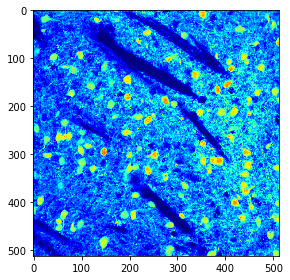

In [2]:
rawpic = io.imread('Drd2_Adult_S_conf_25X_CPU1_cryo_NAV.jpg')
img = rawpic[:,:,1] #extract green channel
io.imshow(img, cmap='jet')

## Image preparation

Tweak the sliders until you end up with bright blobs on a clean dark background. `lower` and `upper` are the cutoffs for contrast stretching. `selem_size` determines the maximum size, in pixels, of objects that will be removed by top-hat filtering. For our sample image, try values of around 80, 95 and 3 respectively.

In [3]:
def contrast_stretch(lower=2, upper=98, selem_size=0):
    p2, p98 = np.percentile(img, (lower, upper))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    selem = morphology.disk(selem_size)
    wht_tophat = morphology.white_tophat(img_rescale,selem=selem)
    io.imshow(img_rescale - wht_tophat, cmap='viridis')
    return img_rescale

processed_image = interactive(contrast_stretch, lower=(0,100,5), upper=(0,100,5), selem_size=(0,10,1))
processed_image

interactive(children=(IntSlider(value=2, description='lower', step=5), IntSlider(value=98, description='upper'…

## Blob detection

This section takes the processed image from above and applies a blob detection technique to it. Tweak the two sliders until as many cells as possible are ringed, with as few false positives. `sigma` determines the upper limit for blob size and `threshold` effectively determines how bright something needs to be before it's marked as a blob.

In [4]:
def detect_dog(sigma=10, threshold=0.4, input_img=processed_image.result):
    img = input_img
    blobs_dog = feature.blob_dog(img, max_sigma=sigma, threshold=threshold)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    fig,axes = plt.subplots(ncols=3, figsize=(16,12))
    ax_im_pairs = list(zip(axes,
                           (rawpic,input_img,rawpic),
                           (False,True,True)
                          ))
    for ax,im,draw in ax_im_pairs:
        ax.imshow(im)
        if draw == True:
            for blob in blobs_dog:
                y,x,r = blob
                c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
                ax.add_patch(c)
    print("{} blobs detected.".format(len(blobs_dog)))
    return blobs_dog
        
hotspots = interactive(detect_dog,
                       sigma=(0,100,5),
                       threshold=(0.0001,1,0.001),
                       input_img=fixed(processed_image.result),
                       continuous_update=False
                      )
hotspots

interactive(children=(IntSlider(value=10, description='sigma', step=5), FloatSlider(value=0.4, description='th…

Some settings can produce blob markers of different sizes. This could be useful for identifying false positives in the future. Run the cell once you're happy with the slider positions to get a size breakdown.

In [5]:
for val,cnt in Counter(hotspots.result[:,2]).most_common():
    print("{}: {}".format(round(val,2), cnt))

9.27: 93
5.79: 14


In [6]:
xy_coords = hotspots.result[:,:2].tolist() #dump out coordinates

## XML output

This exports the coordinates in an XML file that can be loaded by the Fiji cell counter plugin. Make sure that `FILENAME` matches the name of the original image exactly, or the cell counter plugin will throw an error when you try to load the markers.

In [7]:
FILENAME = 'dummy.jpg'

In [8]:
def prettify(elem):
    """
    Return a pretty-printed XML string for the Element.
    From https://gist.github.com/jefftriplett/3980637
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ", encoding="UTF-8").decode('UTF8')

In [9]:
marker_types = list(range(1,9))
marks_to_store = {1: xy_coords}

root = ET.Element("CellCounter_Marker_File")
imgprops = ET.SubElement(root, "Image_Properties")
imgfname = ET.SubElement(imgprops, "Image_Filename")
imgfname.text = FILENAME
markerdata = ET.SubElement(root, "Marker_Data")
curtype = ET.SubElement(markerdata, "Current_Type")
curtype.text = '0'
for i in marker_types:
    marks_container = ET.SubElement(markerdata, "Marker_Type")
    mtype = ET.SubElement(marks_container, "Type")
    mtype.text = str(i)
    if i in marks_to_store.keys():
        for y,x in marks_to_store[i]:
            mark = ET.SubElement(mtype, "Marker")
            markx = ET.SubElement(mark, "MarkerX")
            markx.text = str(int(x))
            marky = ET.SubElement(mark, "MarkerY")
            marky.text = str(int(y))
            markz = ET.SubElement(mark, "MarkerZ")
            markz.text = str(int(1))

with open('{}.xml'.format(FILENAME.split('.')[0]), 'w') as f:
    f.write(prettify(root))